### Install Prerequisite

In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn Caribe
!pip install gradio jinja2

### Importing Libraries

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('C:/Users/JOY/Desktop/Final Project')

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, Accuracy

import Caribe as cb
import gradio as gr

J:\Program Files\Anaconda3\envs\python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading

In [3]:
df = pd.read_csv(os.path.join('datasets/jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

column_names=["short","long"]
df1 = pd.read_csv("datasets/abbrevations.csv",names=column_names)
df2 = pd.read_csv("datasets/emoji_df.csv")
df3 = pd.read_csv("datasets/twitterSlang.csv")

In [4]:
df.head()

,id,comment_text,Toxic,Severe Toxic,Obscene,Threat,Insult,Identity Hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Vectorization

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
vectorizer = TextVectorization(max_tokens=200000,output_sequence_length=1800,output_mode='int')

In [10]:
vectorizer.adapt(X.values)

In [11]:
vectorized_text = vectorizer(X.values)

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) 

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

### BI-LSTM Sequential Model

In [33]:
model = Sequential()

model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

### Summarize Model

In [34]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

### Train Model

In [36]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 2211s 279ms/step - loss: 0.0618 - accuracy: 0.9885 - val_loss: 0.0463 - val_accuracy: 0.9937
Epoch 2/5
6981/6981 [==============================] - 2028s 290ms/step - loss: 0.0458 - accuracy: 0.9887 - val_loss: 0.0387 - val_accuracy: 0.9947
Epoch 3/5
6981/6981 [==============================] - 1936s 277ms/step - loss: 0.0400 - accuracy: 0.9745 - val_loss: 0.0367 - val_accuracy: 0.9945
Epoch 4/5
6981/6981 [==============================] - 1928s 276ms/step - loss: 0.0357 - accuracy: 0.9850 - val_loss: 0.0325 - val_accuracy: 0.9938
Epoch 5/5
6981/6981 [==============================] - 1938s 278ms/step - loss: 0.0320 - accuracy: 0.9940 - val_loss: 0.0284 - val_accuracy: 0.9942


### Ploting Accuracy vs Loss

<Figure size 576x360 with 0 Axes>

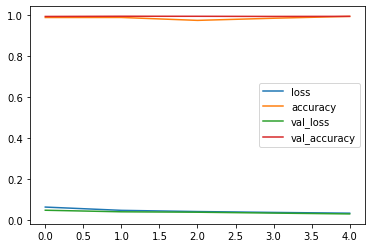

In [38]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

### Model Predictions

In [39]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [40]:
res = model.predict(np.array([input_text]))

In [41]:
(res > 0.1).astype(int)

array([[1, 1, 1, 0, 1, 0]])

### Save the Model

In [46]:
model.save('models/toxicity052.h5')

### Model Evaluation

In [113]:
model = tf.keras.models.load_model('models/toxicity052.h5')

In [115]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator(): 
    
    X_true, y_true = batch
    
    yhat = model.predict(X_true)
    
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

F1 = 2 * ((pre.result().numpy()) * (re.result().numpy())) / ((pre.result().numpy()) + (re.result().numpy()))

In [116]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}, F1:{F1}')

Precision: 0.8774193525314331, Recall:0.8343558311462402, Accuracy:0.5185556411743164, F1:0.8553459469890513


### Pre-Processing Filters

In [ ]:
def preprocessingfilters(comment):
    print("\nOriginal sentence : " ,comment)

    #Slang 
    for i in df3.loc[:, 'slang']:
        comment = comment.lower()
        if(i.lower() in comment.split(" ")):
            j = df3[i==df3['slang']]
            k = j.iloc[-1].values

        comment = comment.lower()
        comment = comment.replace(i.lower(), k[1])
        print("Slang Expanded sentence : " ,comment)

    # Abberivation
    for i in df1.loc[:, 'short']:
        comment = comment.lower()
        if(i.lower() in comment.split(" ")):
            j = df1[i==df1['short']]
            k = j.iloc[-1].values

        comment = comment.lower()
        comment = comment.replace(i.lower(), k[1])
        print("Abberivation Expanded sentence : " ,comment)

    # Emojis
    for i in df2.loc[:, 'emoji']:
        if(i in comment):
            j = df2[i==df2['emoji']]
            k = j.iloc[-1].values

        comment = comment.replace(i, ", having " +k[1])
        print("Emojis Expanded sentence : " ,comment)

    comment=cb.caribe_corrector(comment)
    print("Correct sentence : " ,comment)
    return comment

### Model Testing

In [14]:
model = tf.keras.models.load_model('models/toxicity052.h5')

In [15]:
comment = "Black man killed a child"

comment = preprocessingfilters(comment)

input_str = vectorizer(comment)

In [18]:
results = model.predict(np.array([input_str]))

In [19]:
results

array([[0.8154944 , 0.01688255, 0.07371149, 0.0881749 , 0.27403554,
        0.14557442]], dtype=float32)

In [20]:
text = ''
for idx, col in enumerate(df.columns[2:]):
    text += '{}: {}\n'.format(col, results[0][idx]>0.1)

print(text)

Toxic: True
Severe Toxic: False
Obscene: False
Threat: False
Insult: True
Identity Hate: True



### User Interface

In [21]:
#Importing detoxification function from detox file
from detox import detoxification

### UI Action Function

In [23]:
def score_comment(comment):
    fcomment = preprocessingfilters(comment)
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
        
    if results[0][0] > 0.1:
        pred = detoxification(comment)
        pred = (str(pred)[1:-1]).strip('[\]",')
        pred = str(pred)
    else:
        pred = "Non Toxic Sentence"

    d = []
    for idx, col in enumerate(df.columns[2:]):
        d.append(
            {
                'Catagory': col,
                'Result': results[0][idx] > 0.1,
                'Percent':  round((results[0][idx])*100,2)
            }
        )

    d = pd.DataFrame(d)      
        
    return fcomment,d,pred

### UI Modeling

In [24]:
with gr.Blocks() as interface:
    name = gr.inputs.Textbox(lines=2, placeholder='Enter Your Sentence', label = "Input Sentence")
    greet_btn = gr.Button("Submit")
    output = [gr.Textbox(label="Did you mean?"),gr.Dataframe(label="Toxicity Detection & Classification",headers=['Catagory', 'Result', 'Percent']) , gr.Textbox(label="Detoxification")]
    greet_btn.click(fn=score_comment, inputs=name, outputs=output)

J:\Program Files\Anaconda3\envs\python37\lib\site-packages\gradio\inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
J:\Program Files\Anaconda3\envs\python37\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
J:\Program Files\Anaconda3\envs\python37\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


### UI Launch

In [25]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://98ae21e8cb615d0f.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces



Original sentence :  Black man killed a child
Correct sentence :  A black man killed a child.
[[0.80347824 0.01354027 0.06188534 0.08099121 0.24249987 0.12192699]]

Original sentence :  Black man killed a child.
Correct sentence :  A black man killed a child.
[[0.80347824 0.01354027 0.06188534 0.08099121 0.24249987 0.12192699]]

Original sentence :  Black man killed a child
Correct sentence :  A black man killed a child.
[[0.80347824 0.01354027 0.06188534 0.08099121 0.24249987 0.12192699]]

Original sentence :  I am tired of these school shootings by blacks.
Correct sentence :  I am tired of these school shootings by blacks.
[[2.6347467e-01 9.5619667e-05 1.6185315e-02 4.7464161e-03 3.5410039e-02
  4.4659944e-03]]

Original sentence :  I am tired of these school shootings by black people.
Correct sentence :  I am tired of these school shootings by black people.
[[1.2785305e-01 1.3128197e-05 4.8885201e-03 3.2129425e-03 1.4963361e-02
  4.0048896e-03]]

Original sentence :  trump is so du